In [1]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from scipy.stats import zscore
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

tf.test.gpu_device_name()

2022-12-29 19:25:36.739077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-29 19:25:37.508627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-29 19:25:37.508729: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-29 19:25:37.508735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

'/device:GPU:0'

In [2]:
train  = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_training-set.csv')
test = pd.read_csv('https://raw.githubusercontent.com/Nir-J/ML-Projects/master/UNSW-Network_Packet_Classification/UNSW_NB15_testing-set.csv')

df = pd.concat([train,test]).drop(['id', 'label'], axis=1)

In [3]:
NOMINAL_COLS = ['proto', 'service', 'state']
BINARY_COLS = ['is_sm_ips_ports', 'is_ftp_login']

for name in df.columns:
    if name == "attack_cat" or name in NOMINAL_COLS or name in BINARY_COLS:
        pass
    else:
        df[name] = zscore(df[name])

for name in NOMINAL_COLS:
    df = pd.concat([df, pd.get_dummies(df[name], prefix=name)],axis=1)
    df.drop(name,axis=1,inplace=True)

In [4]:
x = df.drop(['attack_cat'], axis=1).values

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)

dummies = pd.get_dummies(df['attack_cat'])
attack_cat_list = list(dummies.columns)
y = dummies.values

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
models_benchmark = pd.DataFrame(columns=['Accuracy', 'Recall', 'Precision', 'F1-score'])

def getMetrics(model_name, y_truth, y_pred):
    acc = metrics.accuracy_score(y_truth, y_pred)
    rec = metrics.recall_score(y_truth, y_pred, average='macro')
    pre = metrics.precision_score(y_truth, y_pred, average='macro')
    f1s = metrics.f1_score(y_truth, y_pred, average='macro')

    models_benchmark.loc[model_name] = [acc, rec, pre, f1s]
    display(models_benchmark.loc[model_name])
    return

def getCM(model_name, y_test, y_pred):
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,10))
    plt.title(f'{model_name}', fontsize=20)

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', xticklabels=attack_cat_list, yticklabels=attack_cat_list)

    plt.xticks(rotation=45)
    plt.ylabel('Real outcome', fontsize=16)
    plt.xlabel('Predicted outcome', fontsize=16)
    plt.ioff()
    plt.show()
    return

In [7]:
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(128, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(32, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(16, input_dim=x_train.shape[1], activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=1e-3,
    patience=25,
    mode='auto',
    restore_best_weights=True,
    verbose=2
)

2022-12-29 19:25:45.161347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 19:25:45.161677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 19:25:45.161850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 19:25:45.162422: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-29 19:25:45.162725: I tensorflow/compiler/xla/stream_executo

In [8]:
ccw = compute_class_weight(class_weight='balanced', 
                          classes=np.unique(np.unique(df['attack_cat'])), 
                          y=df['attack_cat'])

cw = {i:w for i,w in enumerate(ccw)}
cw

{0: 9.625438924168845,
 1: 11.063675397166167,
 2: 1.5756925334800953,
 3: 0.5787153284671532,
 4: 1.0627443702053947,
 5: 0.43769088345705015,
 6: 0.2770677419354839,
 7: 1.842232072638879,
 8: 17.053143613500993,
 9: 148.08793103448275}

In [9]:
model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    callbacks=[monitor],
    epochs=20000,
    class_weight=cw
)

Epoch 1/20000


2022-12-29 19:25:46.852444: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7faae800cb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-29 19:25:46.852488: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2022-12-29 19:25:46.858349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-29 19:25:46.991823: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6442/6442 [==============================] - 25s 3ms/step - loss: 1.2670 - accuracy: 0.6311 - val_loss: 0.8383 - val_accuracy: 0.6349
Epoch 2/20000
6442/6442 [==============================] - 22s 3ms/step - loss: 1.1655 - accuracy: 0.6439 - val_loss: 0.8433 - val_accuracy: 0.6435
Epoch 3/20000
6442/6442 [==============================] - 22s 3ms/step - loss: 1.1292 - accuracy: 0.6497 - val_loss: 0.7884 - val_accuracy: 0.6421
Epoch 4/20000
6442/6442 [==============================] - 22s 3ms/step - loss: 1.1047 - accuracy: 0.6548 - val_loss: 0.8435 - val_accuracy: 0.6292
Epoch 5/20000
6442/6442 [==============================] - 22s 3ms/step - loss: 1.0975 - accuracy: 0.6599 - val_loss: 0.8213 - val_accuracy: 0.6646
Epoch 6/20000
6442/6442 [==============================] - 23s 4ms/step - loss: 1.0782 - accuracy: 0.6690 - val_loss: 0.8047 - val_accuracy: 0.6523
Epoch 7/20000
6442/6442 [==============================] - 23s 4ms/step - loss: 1.0681 - accuracy: 0.6663 - val_loss: 0.8198 -

1611/1611 [==============================] - 2s 1ms/step


Accuracy     0.678452
Recall       0.596519
Precision    0.479077
F1-score     0.430826
Name: Keras, dtype: float64

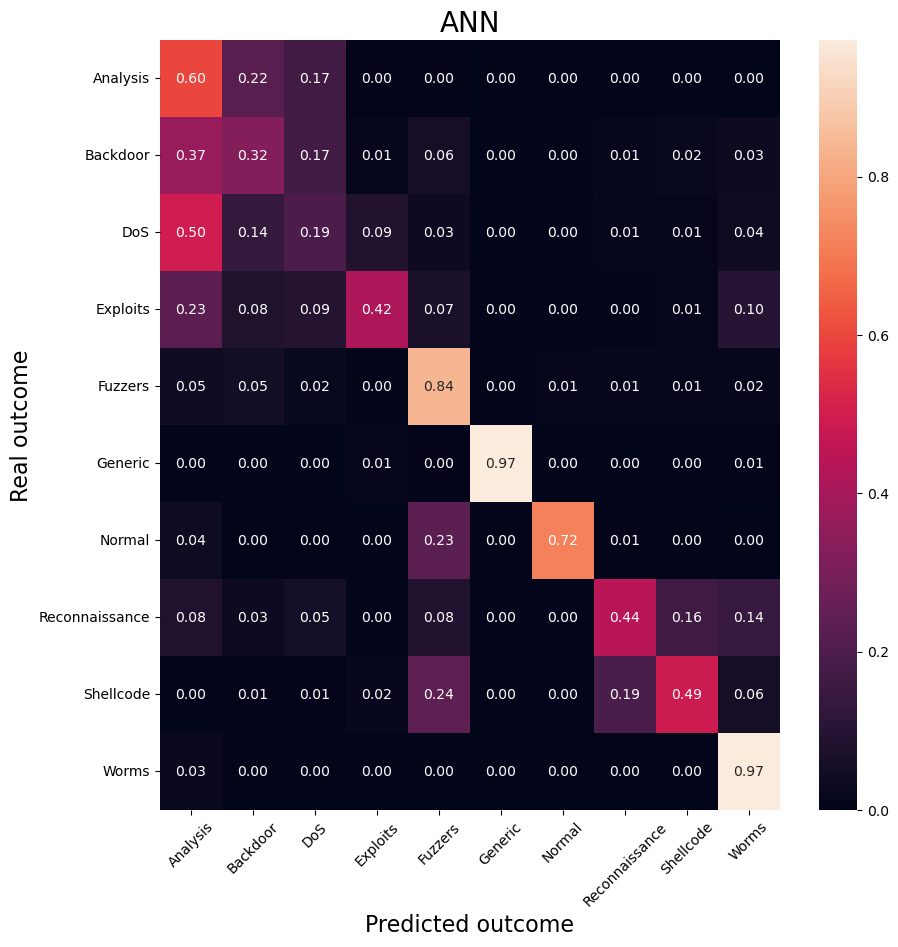

In [10]:
y_pred = model.predict(x_test)

getMetrics(f'Keras', np.argmax(y_test, axis=1), np.argmax(y_pred,axis=1))
getCM('ANN', np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [11]:
model.save("./models/KER1.h5")